<a href="https://colab.research.google.com/github/adamjbradley/fin-base-orchestration/blob/main/Copy_of_Backtesting_demo_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

These packages need to be installed for this tutorial

In [ ]:
# yfinance is to download stock data from yahoo finance, and finta is for adding technical indicators
!pip install yfinance finta

In [81]:
from finta import TA
import pandas as pd
import yfinance as yf
import glob, os
from os import path

import time
import datetime
import random

Define where the user wants to store the stock price data

In [ ]:
#@title Load Files
# data saved to the google colab environment will not persist
# if you want to save data for future sessions, mount your
# google drive and save the files there

folder_root = '/content/drive/MyDrive/Personal/Finance/Trading/data/stocks/'

if input('Save Stock Data to your Google Drive? (y/n)') == 'y':
  if path.exists('/content/drive/MyDrive') == False:
    from google.colab import drive
    drive.mount('/content/drive')
  folder_root = '/content/drive/MyDrive/Personal/Finance/Trading/data/stocks/'
else:
  folder_root = '/content/'


folder_name = input('What folder would you like to use to save price data? (folder will be created if it does not exist)')

if not folder_name or any(c in folder_name for c in r'<>:"\|?*'):
  print('Invalid folder name')

else:
  folder_path = f'{folder_root}{folder_name}'
  print('Folder Path ' + folder_path)

  if path.exists(folder_path) == False:

    try:
      os.makedirs(folder_path)
      print(f'The folder {folder_name} has been created.')
    except OSError as e:
      print(f'Failed to create folder {folder_name}: {e}')

  else:
    print(f'Using path {folder_path}, which already exists')


Save Stock Data to your Google Drive? (y/n)y
Mounted at /content/drive
What folder would you like to use to save price data? (folder will be created if it does not exist)1day/tv
Folder Path /content/drive/MyDrive/Personal/Finance/Trading/data/stocks/1day/tv
Using path /content/drive/MyDrive/Personal/Finance/Trading/data/stocks/1day/tv, which already exists


In [ ]:
#@title Download stock Data
def download_stock_data(folder_location, years=10):

  """Downloads historical daily price data for stocks in the s&p 500 over specified number of years"""

  symbols = pd.read_csv('https://raw.githubusercontent.com/datasets/s-and-p-500-companies/main/data/constituents.csv')['Symbol']

  # remove [0:50] if you want to download all stock data
  # (as written it will download just the first 50)
  #for s in symbols[0:50]:
  for s in symbols:
    try:
      df = yf.download([s], auto_adjust=True, period=f'{str(years)}y', )

      # we need this dataframe to be long enough to test
      if len(df) > 400:
        df.columns = df.columns.str.lower()
        df.index = df.index.rename('datetime')
        df.to_csv(f'{folder_location}/{s}.csv')

    except Exception as e:
      print(f'error with {s}')
      print(repr(e))
      continue

#download_stock_data(folder_path + "/../../1day/yf")
download_stock_data(folder_path)

In [153]:
#@title Strategy - Basic
def find_entries(df:pd.DataFrame) -> pd.DataFrame:

  """Finds entries for this sample strategy:
  Buy when the 50 period EMA crosses above the 200 period EMA,
  and the price is above the 200 period EMA.

  Set a target of 3% above the entry price, and a stop 3% below the entry price
  """

  df['EMA200'] = TA.EMA(df, period=200)
  df['EMA50'] = TA.EMA(df, period=50)


  # conditions for the strategy
  c1 = df.close > df.EMA200
  c2 = df.shift(1).EMA50 < df.shift(1).EMA200
  c3 = df.EMA50 > df.EMA200

  long_entry_condition = (c1) & (c2) & (c3)

  df['buy'] = False
  df['entry'] = df.shift(-1).open
  df['target'] = 0.0
  df['stop'] = 0.0
  df['gain'] = 0.0
  df['length'] = 0
  # 'winner' will be set to:
  #     0 for a losing trade
  #     1 for a winning trade
  #     2 for a trade that times-out
  #     3 for a candle not traded
  df['winner'] = 3

  # lets be specific about the datatypes so pandas doesn't misinterpret:
  df = df.astype({
    'buy': bool,
    'entry': float,
    'target': float,
    'stop': float,
    'gain': float,
    'length': int,
    'winner': int
      })

  df.loc[long_entry_condition, 'buy'] = True
  df.loc[long_entry_condition, 'stop'] = df.entry * 0.97
  df.loc[long_entry_condition, 'target'] = df.entry * 1.03

  return df

In [155]:
#@title Strategy - Buy & Hold
def find_entries(df:pd.DataFrame) -> pd.DataFrame:

  """Finds entries for this sample strategy:
  Buy when the 50 period EMA crosses above the 200 period EMA,
  and the price is above the 200 period EMA.

  Set a target of 3% above the entry price, and a stop 3% below the entry price
  """

  df['ATR'] = TA.ATR(df, period=1)

  df['buy'] = False
  df['entry'] = df.shift(-1).open
  df['target'] = 0.0
  df['stop'] = 0.0
  df['gain'] = 0.0
  df['length'] = 0
  # 'winner' will be set to:
  #     0 for a losing trade
  #     1 for a winning trade
  #     2 for a trade that times-out
  #     3 for a candle not traded
  df['winner'] = 3

  # lets be specific about the datatypes so pandas doesn't misinterpret:
  df = df.astype({
    'buy': bool,
    'entry': float,
    'target': float,
    'stop': float,
    'gain': float,
    'length': int,
    'winner': int
      })


  df.iloc[201, df.columns.get_loc('buy')] = True
  df.iloc[201, df.columns.get_loc('stop')] = df.iloc[201, df.columns.get_loc('entry')] - (df.columns.get_loc('ATR') * 1.6)
  df.iloc[201, df.columns.get_loc('target')] = df.iloc[201, df.columns.get_loc('entry')] + (df.columns.get_loc('ATR') * 1.2)

  #df.loc[long_entry_condition, 'stop'] = df.entry * 0.97
  #df.loc[long_entry_condition, 'target'] = df.entry * 1.03

  return df

In [157]:
#@title Strategy - Random
def find_entries(df:pd.DataFrame) -> pd.DataFrame:

  """Finds entries for this sample strategy:
  Enter at a random bar, trust me, it's awesome
  """

  df['ATR'] = TA.ATR(df, period=1)

  df['buy'] = False
  df['entry'] = df.shift(-1).open
  df['target'] = 0.0
  df['stop'] = 0.0
  df['gain'] = 0.0
  df['length'] = 0
  # 'winner' will be set to:
  #     0 for a losing trade
  #     1 for a winning trade
  #     2 for a trade that times-out
  #     3 for a candle not traded
  df['winner'] = 3

  # lets be specific about the datatypes so pandas doesn't misinterpret:
  df = df.astype({
    'buy': bool,
    'entry': float,
    'target': float,
    'stop': float,
    'gain': float,
    'length': int,
    'winner': int
      })

  number_of_trades = random.randint(1, 50)

  count = 0
  while count < number_of_trades:
    random_buy = random.randint(201, len(df)-1)

    df.iloc[random_buy, df.columns.get_loc('buy')] = True
    df.iloc[random_buy, df.columns.get_loc('stop')] = df.iloc[random_buy, df.columns.get_loc('entry')] - (df.columns.get_loc('ATR') * 1.6)
    df.iloc[random_buy, df.columns.get_loc('target')] = df.iloc[random_buy, df.columns.get_loc('entry')] + (df.columns.get_loc('ATR') * 1.2)

    #df.loc[long_entry_condition, 'stop'] = df.entry * 0.97
    #df.loc[long_entry_condition, 'target'] = df.entry * 1.03

    count = count + 1

  return df

In [159]:
#@title Strategy - New strategy!

def find_entries(df:pd.DataFrame) -> pd.DataFrame:

  """Finds entries for this sample strategy:
  1. Red Candle with low below lower bollinger band
  2. RSI is above 25 (red candle)
  3. Next Candle is green, and closes above the high of the prior red candle
  4. Bolling Bandwidth > threshold (0.3 for daily, 0.15 for 30 minute)
  """

  #From https://snyk.io/advisor/python/finta/functions/finta.finta.TA
  BB = TA.BBANDS(df, period=30)
  df['BB_UPPER'] = BB["BB_UPPER"]
  df['BB_LOWER'] = BB["BB_LOWER"]

  df['BBW'] = TA.BBWIDTH(df, period=30)
  df['RSI'] = TA.RSI(df, period=14)
  df['ATR'] = TA.ATR(df, period=1)

  c0 = df.close.shift(1) < df.close.shift(2)
  c1 = df.close.shift(1) < df.shift(1).BB_LOWER
  c2 = df.shift(1).RSI < rsi
  c3 = df.close > df.high.shift(1)
  c4 = df.BBW > bbw

  long_entry_condition = (c0) & (c1) & (c2) & (c3) & (c4)

  df['buy'] = False
  df['entry'] = df.shift(-1).open
  df['target'] = 0.0
  df['stop'] = 0.0
  df['gain'] = 0.0
  df['length'] = 0
  # 'winner' will be set to:
  #     0 for a losing trade
  #     1 for a winning trade
  #     2 for a trade that times-out
  #     3 for a candle not traded
  df['winner'] = 3

  # lets be specific about the datatypes so pandas doesn't misinterpret:
  df = df.astype({
    'buy': bool,
    'entry': float,
    'target': float,
    'stop': float,
    'gain': float,
    'length': int,
    'winner': int
      })


  df.loc[long_entry_condition, 'buy'] = True
  df.loc[long_entry_condition, 'stop'] = df.entry - (df.ATR * stop)
  df.loc[long_entry_condition, 'target'] = df.entry + (df.ATR * target)

  return df

In [269]:
#@title Find all entries

def find_all_entries(folder_path):
  # create a list of all the csv files in our chosen folder
  filepaths = [file for file in glob.glob(f'{folder_path}/*.csv')]
  results_dict = {}

  # for each file csv file path, get the stock symbol from the file path,
  # and load the csv, process it to add the entries, targets, and stops,
  # and add it to a dictionary where the symbol is the dictionary key

  for p in filepaths:

    df = pd.DataFrame()

    try:
      # this needs to be date, not datetime for non-yahoo sources
      if ("yf" in folder_path):
        df = pd.read_csv(p, index_col='datetime')
      else:
        df = pd.read_csv(p, index_col='date')
      df = df.sort_index(ascending=True)

      # we need this dataframe to be long enough to test
      if len(df) > 400:
        symbol = p.split('/')[-1].split('.')[0]
        df = find_entries(df)
        df['symbol'] = symbol

        # make the index just integers rather than dates, but save the dates
        # in another column
        df = df.reset_index(drop=False)
        results_dict[symbol] = df

    except Exception as e:
      print(f'Error with filepath {p}', repr(e))

  print(f'Read {len(results_dict.keys())} stocks')
  return results_dict

def show_results():
  print(f'Using {folder_path}')
  print(f'Bollinger bandwidth {bbw}')
  print(f'Mean gain {results_df.gain.mean()}')
  print(f'Sum of results {results_df.gain.sum()}')
  print(f'Number of trades {len(results_df)}')
  print(f'Days in trades {results_df.length.sum()}')
  print(f'Average trade length {results_df.length.sum()/len(results_df)}')
  print(f'Percentage wins {len(results_df[results_df.gain > 0]) / len(results_df)}')
  print(f'Percentage loss {1-(len(results_df[results_df.gain > 0]) / len(results_df))}')

Lets load just one of these price histories

In [ ]:
#@title Process single stock - price histories
# Yahoo
#x = results_dict['A']

# Tiingo
#x = results_dict['AAL_STOCKS_1day_3650days_ohlc_tiingo']
#x = results_dict['ADP_STOCKS_15min_3650days_ohlc_tiingo']
#x = results_dict['AAL_STOCKS_1hour_3650days_ohlc_tiingo']
x = results_dict['A_STOCKS_1hour_3650days_ohlc_tiingo']
#x = results_dict['A_STOCKS_1day_3650days_ohlc_tiingo']
x

These are the rows that were buy signals for the strategy

In [ ]:
#@title Process single stock - indices
buy_indices = x[x.buy==True].index.tolist()
buy_indices

[]

This code will run the trading simulation on this one stock

In [ ]:
#@title Process single stock - backtest

# we want to set a maximum trading length so all trades
# get equal treatment whether they are at the beginning
# of the dataframe or near the end.  The maximum number
# of candles to let the trade go is completely up to you

max_trade_length = 50

# we also have to set a minimum row number to accept
# as a valid trade... since we use a 200 period moving
# average, we can't use any buy signal that is before
# row 200
min_starting_index = 200

for i in buy_indices:

  # if the buy signal is too close to the end of price data,
  # or before minimum starting index, then skip it
  if (i > len(x) - max_trade_length - 1) | (i < min_starting_index):
    x.loc[i, 'buy'] = False
    continue


  i = int(i)
  trading_slice = x.iloc[i+1:i+max_trade_length].copy()
  target_price = x.iloc[i].target
  stop_price = x.iloc[i].stop
  entry_price = x.iloc[i].entry
  winning_indices = trading_slice[trading_slice.high > target_price].index.tolist()
  losing_indices = trading_slice[trading_slice.low < stop_price].index.tolist()

  # find the first occurance of hitting profit target or stop, if any
  if len(winning_indices) > 0:
    winning_index = winning_indices[0]

  if len(losing_indices) > 0:
    losing_index = losing_indices[0]


  # find out if profit target or stop loss was hit first:
  if len(winning_indices) > 0:
    x.loc[i, 'winner'] = 1
    x.loc[i, 'length'] = winning_index - i

    # the winning sell price might be the target price,
    # but if the candle opens higher than the target, it would
    # sell at that higher price
    sell_price = max(x.iloc[winning_index].open, target_price)

    x.loc[i, 'gain'] = (sell_price / entry_price) - 1

    if len(losing_indices) > 0 :
      if losing_index <= winning_index:
        x.loc[i, 'winner'] = 0
        x.loc[i, 'length'] = losing_index - i

        # the losing sell price might be the stop price,
        # but if the candle opens lower than the stop, it would
        # sell at that lower opening price
        sell_price = min(x.iloc[losing_index].open, stop_price)
        x.loc[i, 'gain'] = (sell_price / entry_price) - 1

  elif len(losing_indices) > 0:
    x.loc[i, 'winner'] = 0
    x.loc[i, 'length'] = losing_index - i
    sell_price = min(x.iloc[losing_index].open, stop_price)
    x.loc[i, 'gain'] = (sell_price / entry_price) - 1


  # if price doesn't hit stop or target within the maximum
  # allowed trading time, then sell at the close of final candle
  if (len(winning_indices) == 0) & (len(losing_indices) == 0):
    x.loc[i, 'length'] = max_trade_length
    x.loc[i, 'winner'] = 2
    x.loc[i, 'gain'] = (trading_slice.iloc[-1]['close'] / entry_price) - 1


Here's a list of the trades that were calculated for this stock

In [ ]:
#@title Process single - buy signals
stockx[x.buy ==True]
x[x.buy ==True].gain.mean()

Now we can take the code used to calculate the trades for one stock, and loop it over all the stocks, saving all the trades in a master dataframe called results_df

In [270]:
#@title !!! Backtest - Process all stocks - update buy signals and run backtest

def run_backtest(get_results, results_dict, folder_path):
  results_df = pd.DataFrame()

  if (get_results is True):
    print(f"Retrieving results_dict from {folder_path}")
    results_dict = find_all_entries(folder_path)

  for key in results_dict.keys():

    x = results_dict[key]

    buy_indices = x[x.buy==True].index.tolist()

    for i in buy_indices:

      # if the buy signal is too close to the end of price data,
      # or before minimum starting index, then skip it
      if (i > len(x) - max_trade_length - 1) | (i < min_starting_index):
        x.loc[i, 'buy'] = False
        continue

      trading_slice = x.iloc[i+1:i+max_trade_length].copy()
      target_price = x.iloc[i].target
      stop_price = x.iloc[i].stop
      entry_price = x.iloc[i].entry

      units = int(trade_size / entry_price)

      winning_indices = trading_slice[trading_slice.high > target_price].index.tolist()
      losing_indices = trading_slice[trading_slice.low < stop_price].index.tolist()

      # find the first occurance of hitting profit target or stop, if any
      if len(winning_indices) > 0:
        winning_index = winning_indices[0]

      if len(losing_indices) > 0:
        losing_index = losing_indices[0]

      # find out if profit target or stop loss was hit first:
      if len(winning_indices) > 0:
        x.loc[i, 'winner'] = 1
        x.loc[i, 'length'] = winning_index - i

        # the winning sell price might be the target price,
        # but if the candle opens higher than the target, it would
        # sell at that higher price
        sell_price = max(x['open'].iloc[winning_index], target_price)

        #x.loc[i, 'gain'] = (sell_price / entry_price) - 1
        x.loc[i, 'gain'] = (sell_price - entry_price) * units

        if len(losing_indices) > 0 :
          if losing_index <= winning_index:
            x.loc[i, 'winner'] = 0
            x.loc[i, 'length'] = losing_index - i

            # the losing sell price might be the stop price,
            # but if the candle opens lower than the stop, it would
            # sell at that lower opening price
            sell_price = min(x['open'].iloc[losing_index], stop_price)
            #x.loc[i, 'gain'] = (sell_price / entry_price) - 1
            x.loc[i, 'gain'] = (sell_price - entry_price) * units

      elif len(losing_indices) > 0:
        x.loc[i, 'winner'] = 0
        x.loc[i, 'length'] = losing_index - i
        sell_price = min(x['open'].iloc[losing_index], stop_price)
        #x.loc[i, 'gain'] = (sell_price / entry_price) - 1
        x.loc[i, 'gain'] = (sell_price - entry_price) * units


      # if price doesn't hit stop or target within the maximum
      # allowed trading time, then sell at the close of final candle
      if (len(winning_indices) == 0) & (len(losing_indices) == 0):
        x.loc[i, 'length'] = max_trade_length

        if (trading_slice.iloc[-1]['close'] - entry_price > 0):
          x.loc[i, 'winner'] = 1
        else:
          x.loc[i, 'winner'] = 0

        #x.loc[i, 'gain'] = (trading_slice.iloc[-1]['close'] / entry_price) - 1
        x.loc[i, 'gain'] = (trading_slice.iloc[-1]['close'] - entry_price) * units


    # take the trades and add them to our results dataframe
    results_df = pd.concat([results_df, x[x.buy==True]], ignore_index=True)

  return results_df

In [311]:
max_trade_length = 20
min_starting_index = 1
bbw = 0.30
rsi = 25
stop = 1.6
target = 1.2
trade_size = 1000

#folder_path = f'{folder_root}1day/tv-2years'
#folder_path = f'{folder_root}1day/tv-10years'
#folder_path = f'{folder_root}1day/yf'
#folder_path = f'{folder_root}1day/yf-5years'
#folder_path = f'{folder_root}1day/s-and-p-500-2years'
#folder_path = f'{folder_root}1day/s-and-p-500-10years'
#folder_path = f'{folder_root}1day/russell-2000-2years'
folder_path = f'{folder_root}1day/russell-3000'

#folder_path = f'{folder_root}30min/tv-10years'
#folder_path = f'{folder_root}30min/russell-2000-2years'
#folder_path = f'{folder_root}30min/s-and-p-500-2years'

#folder_path = f'{folder_root}1hour/tv'


results_df = run_backtest(True, None, folder_path)
show_results()

Retrieving results_dict from /content/drive/MyDrive/Personal/Finance/Trading/data/stocks/1day/russell-3000
Read 2631 stocks
Using /content/drive/MyDrive/Personal/Finance/Trading/data/stocks/1day/russell-3000
Bollinger bandwidth 0.3
Mean gain 22.854412957198438
Sum of results 35241.50477999999
Number of trades 1542
Days in trades 15034
Average trade length 9.749675745784694
Percentage wins 0.569390402075227
Percentage loss 0.43060959792477305


<Axes: >

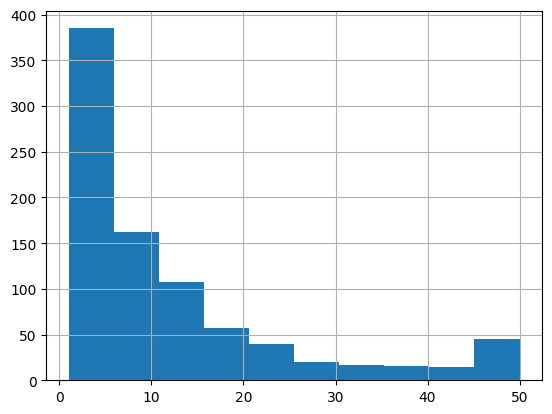

In [292]:
results_df[results_df['gain'] > 0].length.hist()

<Axes: >

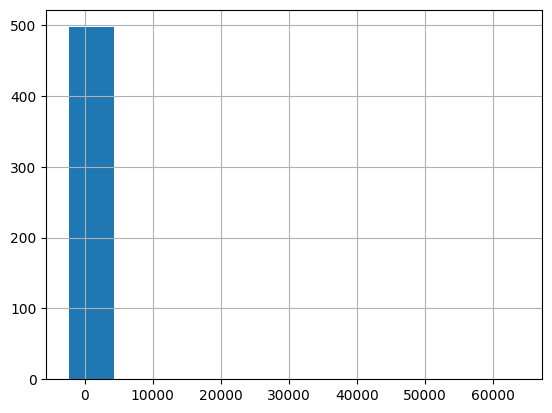

In [297]:
results_df.gain.hist()

In [303]:
results_df[results_df.length < 3].gain.mean()

167.9177175

And here's all the trades we simulated

In [283]:
#@title Show all trades
# Use this for Yahoo downloads
#results_df[['datetime', 'symbol', 'buy', 'entry', 'target', 'stop', 'gain', 'length', 'winner']]
# Use this for tiingo downloads
results_df[['date', 'symbol', 'buy', 'entry', 'target', 'stop', 'gain', 'length', 'winner']]

,date,symbol,buy,entry,target,stop,gain,length,winner
0,2022-05-23 00:00:00+00:00,COST_STOCKS_1day_730days_ohlc_tiingo,True,424.800,446.51200,400.37400,48.60000,3,1
1,2022-02-09 00:00:00+00:00,META_STOCKS_1day_730days_ohlc_tiingo,True,228.270,249.37400,204.52800,-103.72000,8,0
2,2022-11-04 00:00:00+00:00,META_STOCKS_1day_730days_ohlc_tiingo,True,94.780,100.06000,88.84000,69.40000,3,1
3,2023-08-21 00:00:00+00:00,TSLA_STOCKS_1day_730days_ohlc_tiingo,True,240.250,266.88088,210.29026,19.04000,10,1
4,2023-03-21 00:00:00+00:00,WFC_STOCKS_1day_730days_ohlc_tiingo,True,38.705,41.07300,36.04100,-67.62500,3,0
...,...,...,...,...,...,...,...,...,...
1580,2023-10-30 00:00:00+00:00,CARA_STOCKS_1day_730days_ohlc_tiingo,True,1.150,1.42200,0.84400,-86.90000,10,0
1581,2022-02-24 00:00:00+00:00,NRDS_STOCKS_1day_730days_ohlc_tiingo,True,11.360,14.49600,7.83200,0.88000,10,1
1582,2022-05-12 00:00:00+00:00,NRDS_STOCKS_1day_730days_ohlc_tiingo,True,8.820,11.04400,6.31800,133.34000,10,1
1583,2022-07-01 00:00:00+00:00,NRDS_STOCKS_1day_730days_ohlc_tiingo,True,8.160,9.06208,7.14516,110.05376,2,1


Now we can use some basic pandas features to gain insights into the results

<Axes: ylabel='Frequency'>

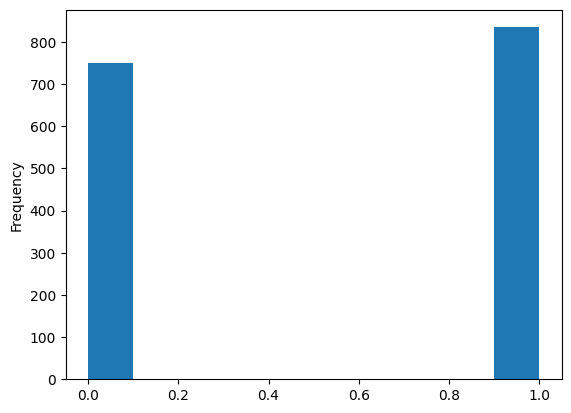

In [284]:
results_df.winner.plot.hist()

In [285]:
results_df[results_df.length<3].gain.mean()

49.3841946969697

In [286]:
len(results_df[results_df.gain>0])/len(results_df[results_df.gain<1])

1.1059602649006623

<Axes: >

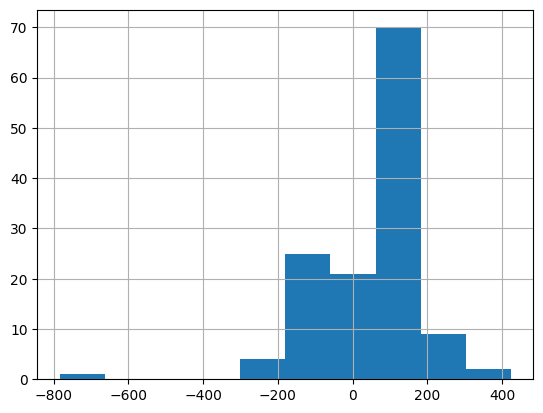

In [287]:
results_df[results_df.length<3].gain.hist()

In [ ]:
#@title Let's print some results
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

out = display(progress(0, 100), display_id=True)
for ii in range(101):
    time.sleep(0.02)
    out.update(progress(ii, 100))